# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root_path = 'gdrive/MyDrive/Capstone_Project_Style_Transfer_using_GAN/'

Mounted at /content/drive


In [2]:
!unrar x "/content/drive/MyDrive/Capstone_Project_Style_Transfer_using_GAN/MRI+T1_T2+Dataset.RAR"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Capstone_Project_Style_Transfer_using_GAN/MRI+T1_T2+Dataset.RAR

Creating    Tr1                                                       OK
Extracting  Tr1/.DS_Store                                                  0%  OK 
Creating    Tr1/TrainT1                                               OK
Extracting  Tr1/TrainT1/Image #10.png                                      1%  OK 
Extracting  Tr1/TrainT1/Image #11.png                                      2%  OK 
Extracting  Tr1/TrainT1/Image #12.png                                      3%  OK 
Extracting  Tr1/TrainT1/Image #13.png                                      4%  OK 
Extracting  Tr1/TrainT1/Image #14.png                                      5%  OK 
Extracting  Tr1/TrainT1/Image #15.png                                      6%  OK 
Extracting  Tr1/TrainT1/Image #16.png

In [3]:
#Import all the required libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob

import warnings
warnings.filterwarnings('ignore')

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [4]:
batch_size = 1
img_height = 256
img_width = 256

In [5]:
def LoadImages(path, size=(img_height,img_width)):
    DataList = list()
    
    for file in listdir(path):
        pixels = load_img(path+file, target_size=size)

        pixels = img_to_array(pixels)

        DataList.append(pixels)
        
    return asarray(DataList)

In [6]:
import os
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray

#write your code to create the dataset from image directory

tr1_mri = LoadImages('/content/Tr1/TrainT1/') 

#convert to grayscale

tr1_mri = tf.image.rgb_to_grayscale(tr1_mri) 

tr1= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_mri))

tr1

<TensorSliceDataset shapes: (256, 256, 1), types: tf.float32>

In [7]:
#write your code to create the dataset from image directory

tr2_mri = LoadImages('/content/Tr2/TrainT2/') 

#convert to grayscale

tr2_mri = tf.image.rgb_to_grayscale(tr2_mri) 

tr2= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_mri))

tr2

<TensorSliceDataset shapes: (256, 256, 1), types: tf.float32>

## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [8]:
# normalizing the images to [-1, 1]

def normalize(image):

    image = tf.cast(image, tf.float32)

    image = (image / 127.5) - 1
    
    return image

In [9]:
def preprocess_image_train(image):

    image = tf.image.random_flip_left_right(image)

    image = normalize(image)
    
    return image

In [10]:
# process both classes of MRI images

buffer_size = 1000

AUTOTUNE = tf.data.experimental.AUTOTUNE

tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)


In [11]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

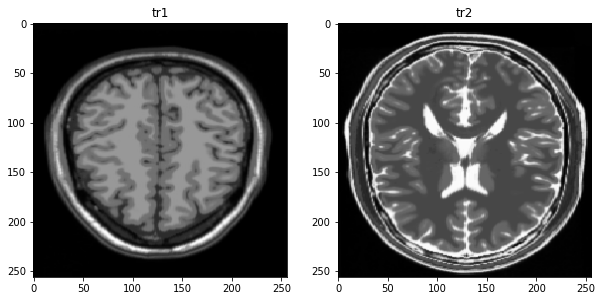

In [40]:
plt.figure(figsize= (10,10))
plt.subplot(121)
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

plt.subplot(122)
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):

        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):

        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
        
    def call(self, x):

        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    result.add(tf.keras.layers.Conv2D(filters, 
                                      size, 
                                      strides=2, 
                                      padding='same',
                                      kernel_initializer=initializer, 
                                      use_bias=False))
    
    if apply_norm:

        result.add(InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    result.add(tf.keras.layers.Conv2DTranspose(filters, 
                                               size, 
                                               strides=2, 
                                               padding='same',
                                               kernel_initializer=initializer, 
                                               use_bias=False))
    
    result.add(InstanceNormalization())

    if apply_dropout:

        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    
    return result

In [15]:
def unet_generator():
  
    down_stack = [downsample(64,4, False),
                  downsample(128,4),
                  downsample(256,4),
                  downsample(512,4),
                  downsample(512,4),
                  downsample(512,4),
                  downsample(512,4),
                  downsample(512,4),
                  ]

    up_stack = [upsample(512, 4, True),
                upsample(512, 4, True),
                upsample(512, 4, True),
                upsample(512, 4),
                upsample(256, 4),
                upsample(128, 4),
                upsample(64, 4),
                ]
        
    initializer = tf.random_normal_initializer(0., 0.02)

    last = tf.keras.layers.Conv2DTranspose(1, 
                                           4, 
                                           strides=2, 
                                           padding='same', 
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)

    #concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None, None, 1])

    x = inputs

    # Downsampling through the model
    skips = []

    for down in down_stack:

        x = down(x)

        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):

        x = up(x)

        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

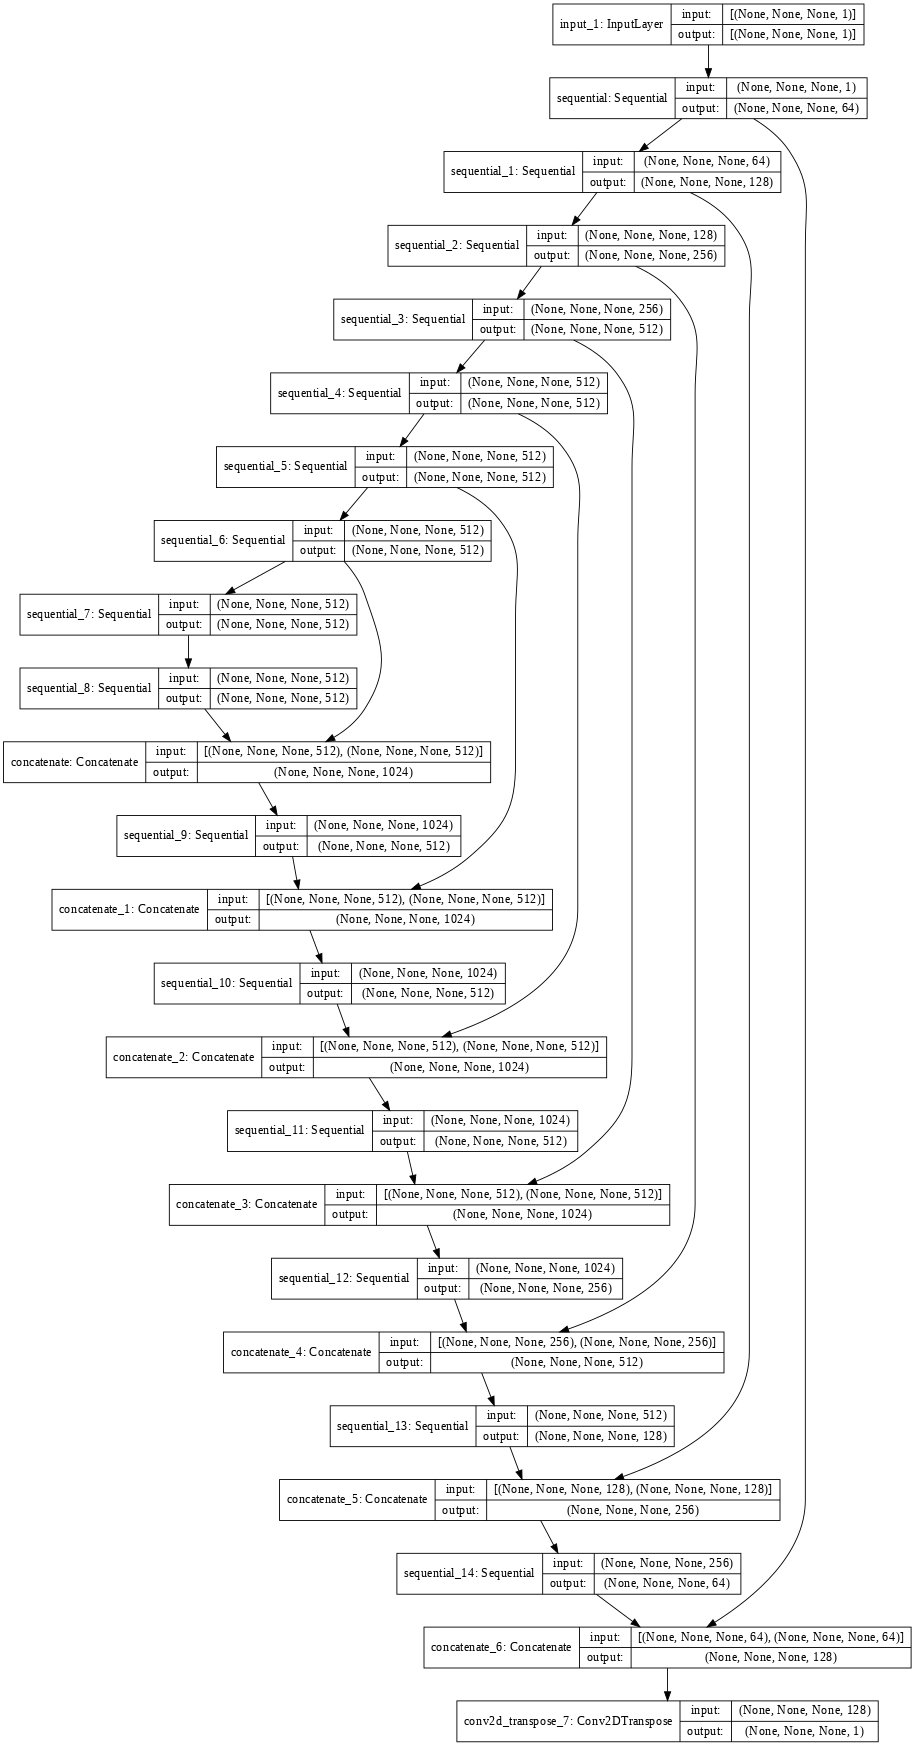

In [16]:
generator_g = unet_generator() #initialise the generator

tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

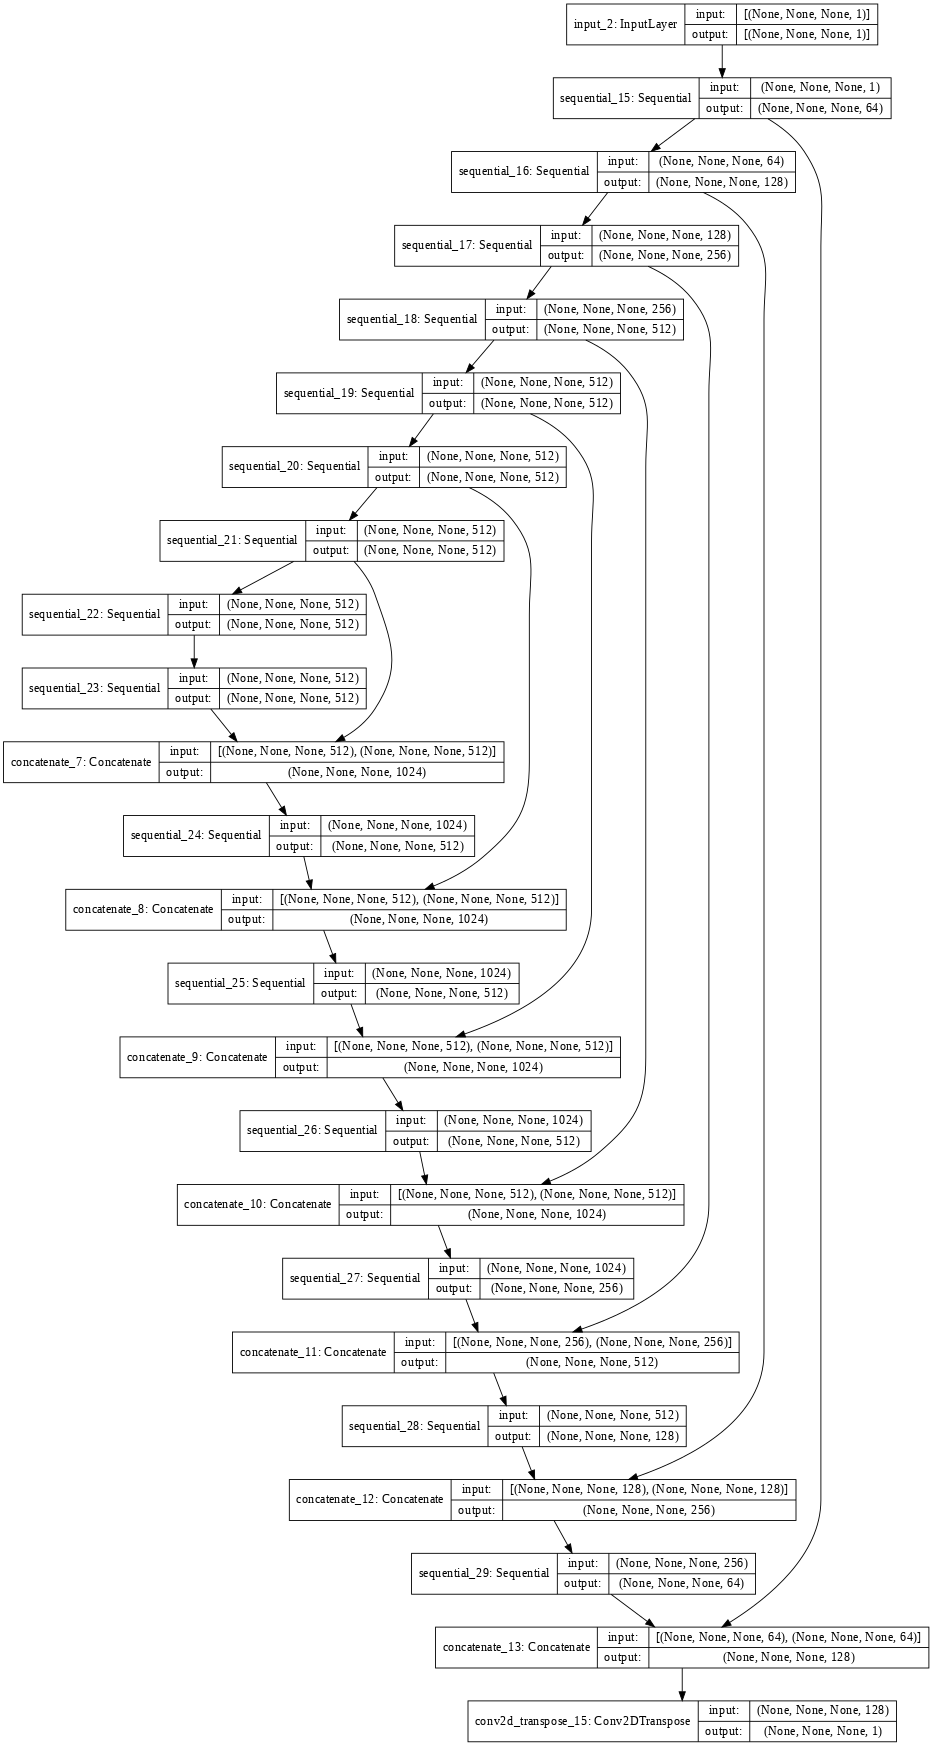

In [17]:
generator_f = unet_generator() #initialise the generator

tf.keras.utils.plot_model(generator_f, show_shapes=True, dpi=64)

In [18]:
def discriminator():
  
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) #write your code to downsample X
    down2 = downsample(128, 4)(down1)   #write your code to downsample down1
    down3 = downsample(256, 4)(down2)   #write your code to downsample down2

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)

    conv = tf.keras.layers.Conv2D(512, 
                                  4, 
                                  strides=1, 
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 
                                  4, 
                                  strides=1, 
                                  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp], outputs=last) #create the model using input & output layer

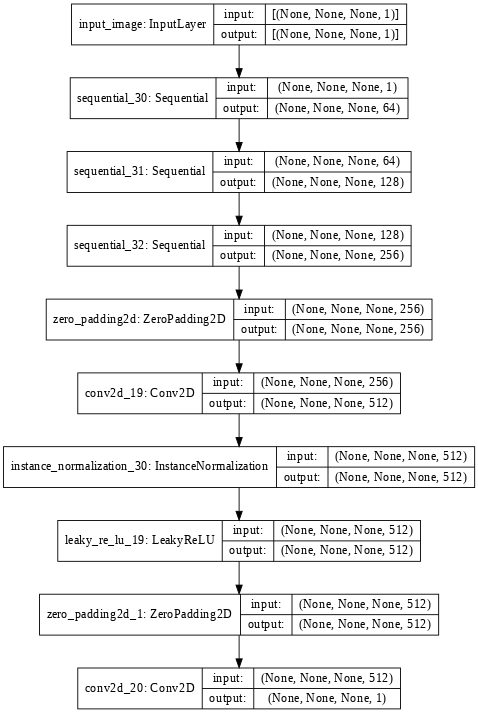

In [19]:
discriminator_x = discriminator() #initialise the discriminator

tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

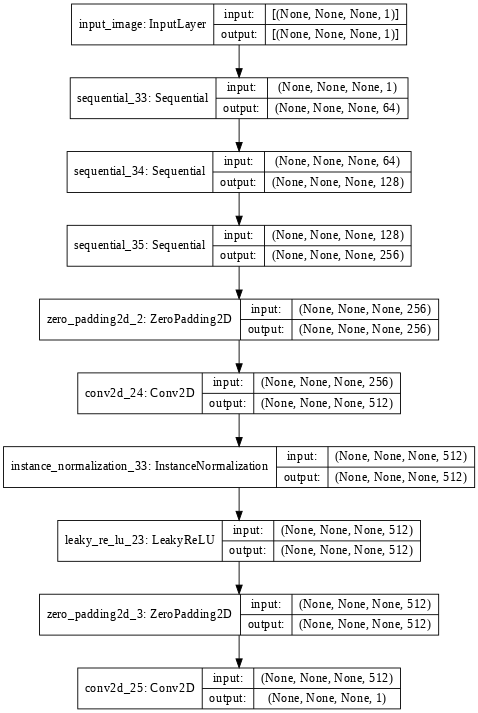

In [20]:
discriminator_y = discriminator() #initialise the discriminator

tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

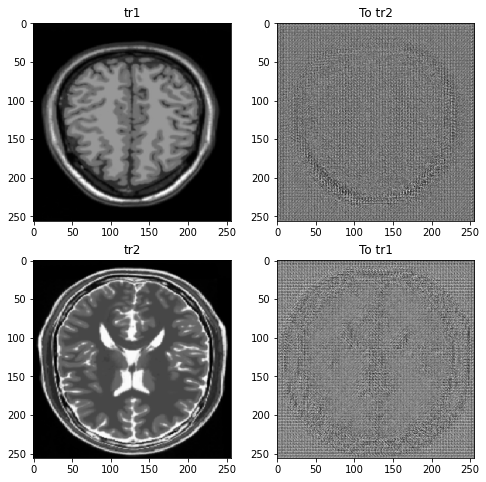

In [21]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]

title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])

    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
        
plt.show()

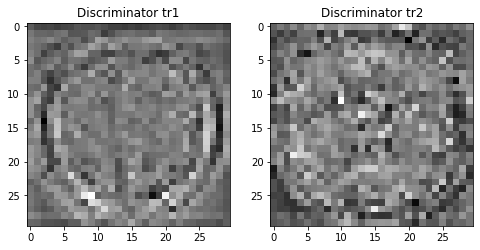

In [22]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Discriminator tr1')
plt.imshow(discriminator_y(sample_tr1)[0, ..., -1], cmap='gray')

plt.subplot(122)
plt.title('Discriminator tr2')
plt.imshow(discriminator_x(sample_tr2)[0, ..., -1], cmap='gray')

plt.show()

In [23]:
LAMBDA = 10 #"Your Lambda Value Here"

In [24]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) #"Your Binary-Cross-Entropy Loss Here"

In [25]:
def discriminator_loss(real, generated):
    
    real_loss = loss_obj(tf.ones_like(real),real) #write your code here
    
    generated_loss = loss_obj(tf.zeros_like(generated), generated) #write your code here
    
    total_disc_loss = real_loss + generated_loss #write your code here
    
    return total_disc_loss * 0.5

In [26]:
def generator_loss(generated):
  
    return loss_obj(tf.ones_like(generated), generated)

In [27]:
def calc_cycle_loss(real_image, cycled_image):
  
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [28]:
def identity_loss(real_image, same_image):

    loss = tf.reduce_mean(tf.abs(real_image - same_image))

    return LAMBDA * 0.5 * loss

In [29]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
EPOCHS = 40 #"Your Number of Epochs Here"

In [31]:
checkpoint_path = "/content/Trained_model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,

                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,

                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,

                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, 
                                          checkpoint_path, 
                                          max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.

if ckpt_manager.latest_checkpoint:
  
    ckpt.restore(ckpt_manager.latest_checkpoint)

    print ('Latest checkpoint restored!!')

In [32]:
def generate_images(model, test_input, expected_output):

    prediction = model(test_input)

    plt.figure(figsize=(10, 10))
    
    display_list = [test_input[0], prediction[0], expected_output[0]]

    title = ['Input Image', 'Predicted Image', 'Expected Image']

    for i in range(3):

        plt.subplot(1, 3, i+1)

        plt.title(title[i])

        # getting the pixel values between [0, 1] to plot it.

        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

        plt.axis('off')

    plt.show()

In [33]:
@tf.function

def train_step(real_x, real_y):

    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.

    with tf.GradientTape(persistent=True) as tape:

        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True) #write your code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True) #write your code to generate images susiing Generator_f on fake_y
        
        fake_x = generator_f(real_y, training=True) #write your code to generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training=True) #write your code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) #write your code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training=True) #write your code to generate images using Generator_g on real_y
        
        disc_real_x = discriminator_x(real_x, training=True) #write your code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training=True) #write your code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training=True) #write your code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training=True) #write your code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables) 
    
    # Apply the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))


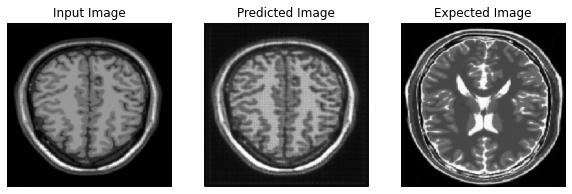

Saving checkpoint for epoch 0 at /content/Trained_model/ckpt-1


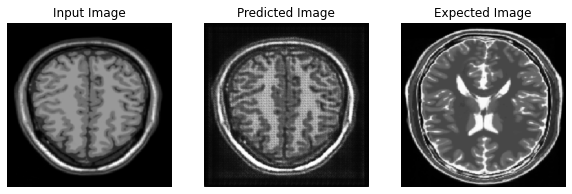

Saving checkpoint for epoch 1 at /content/Trained_model/ckpt-2


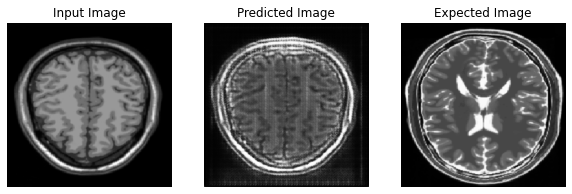

Saving checkpoint for epoch 2 at /content/Trained_model/ckpt-3


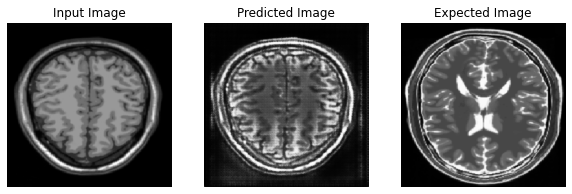

Saving checkpoint for epoch 3 at /content/Trained_model/ckpt-4


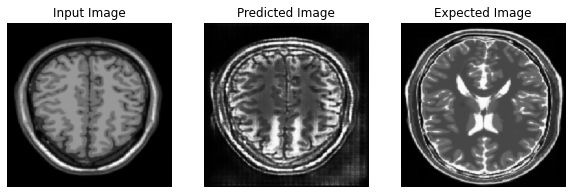

Saving checkpoint for epoch 4 at /content/Trained_model/ckpt-5


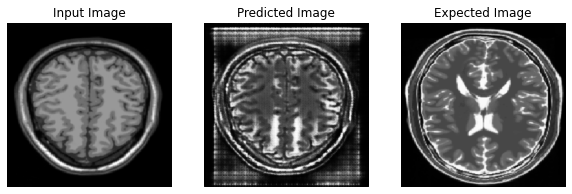

Saving checkpoint for epoch 5 at /content/Trained_model/ckpt-6


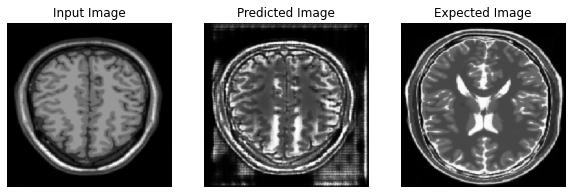

Saving checkpoint for epoch 6 at /content/Trained_model/ckpt-7


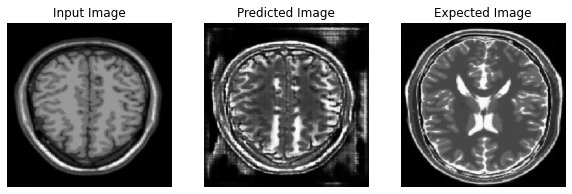

Saving checkpoint for epoch 7 at /content/Trained_model/ckpt-8


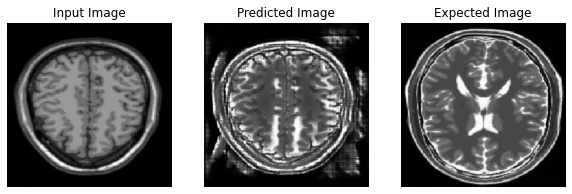

Saving checkpoint for epoch 8 at /content/Trained_model/ckpt-9


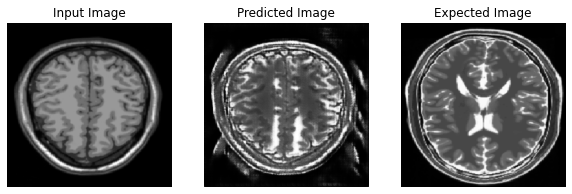

Saving checkpoint for epoch 9 at /content/Trained_model/ckpt-10


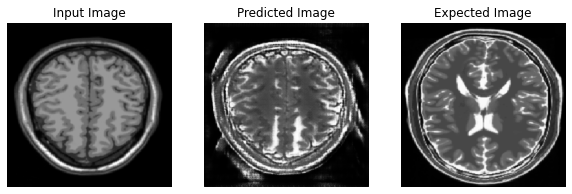

Saving checkpoint for epoch 10 at /content/Trained_model/ckpt-11


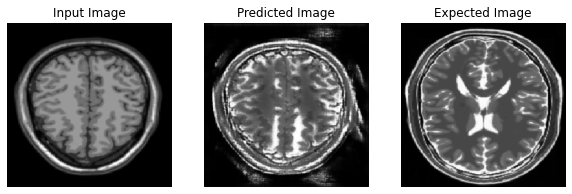

Saving checkpoint for epoch 11 at /content/Trained_model/ckpt-12


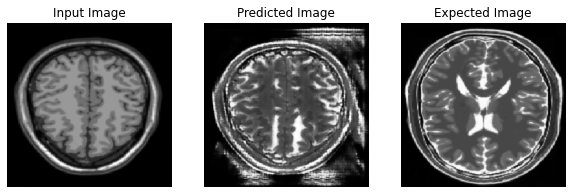

Saving checkpoint for epoch 12 at /content/Trained_model/ckpt-13


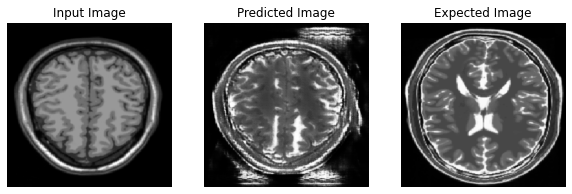

Saving checkpoint for epoch 13 at /content/Trained_model/ckpt-14


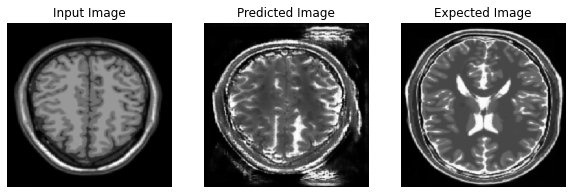

Saving checkpoint for epoch 14 at /content/Trained_model/ckpt-15


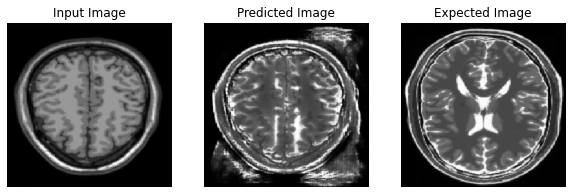

Saving checkpoint for epoch 15 at /content/Trained_model/ckpt-16


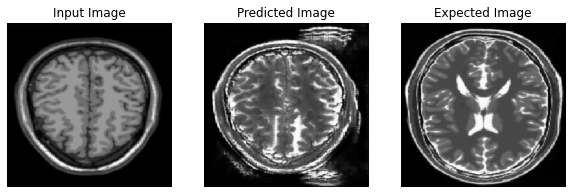

Saving checkpoint for epoch 16 at /content/Trained_model/ckpt-17


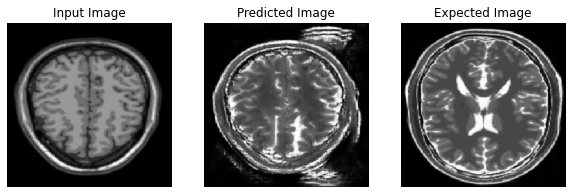

Saving checkpoint for epoch 17 at /content/Trained_model/ckpt-18


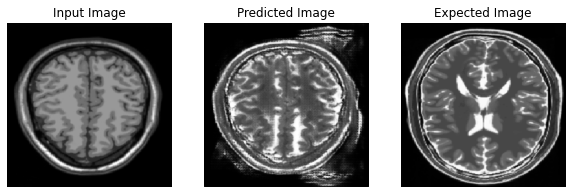

Saving checkpoint for epoch 18 at /content/Trained_model/ckpt-19


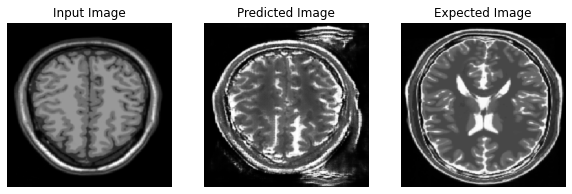

Saving checkpoint for epoch 19 at /content/Trained_model/ckpt-20


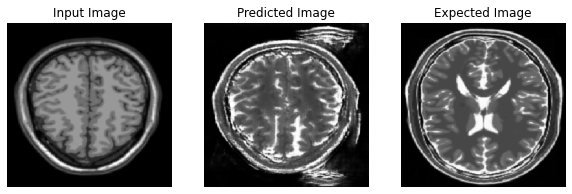

Saving checkpoint for epoch 20 at /content/Trained_model/ckpt-21


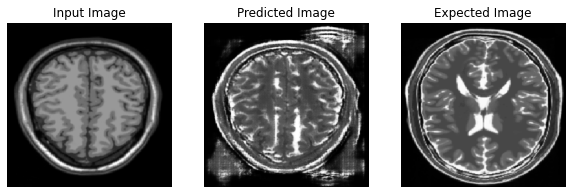

Saving checkpoint for epoch 21 at /content/Trained_model/ckpt-22


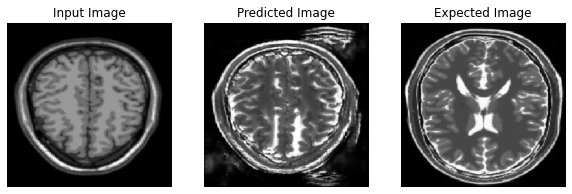

Saving checkpoint for epoch 22 at /content/Trained_model/ckpt-23


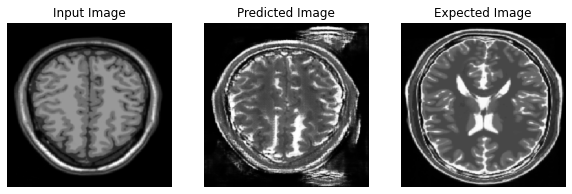

Saving checkpoint for epoch 23 at /content/Trained_model/ckpt-24


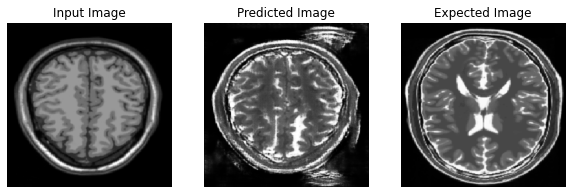

Saving checkpoint for epoch 24 at /content/Trained_model/ckpt-25


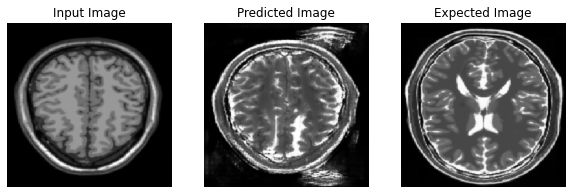

Saving checkpoint for epoch 25 at /content/Trained_model/ckpt-26


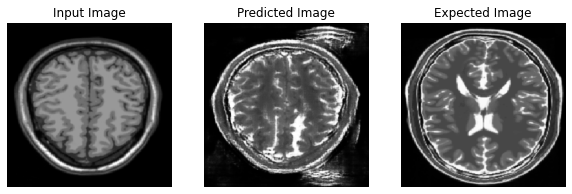

Saving checkpoint for epoch 26 at /content/Trained_model/ckpt-27


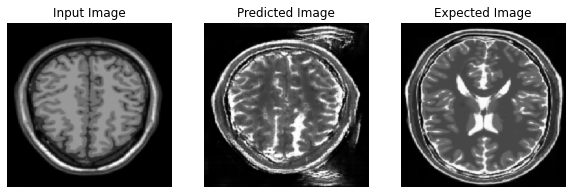

Saving checkpoint for epoch 27 at /content/Trained_model/ckpt-28


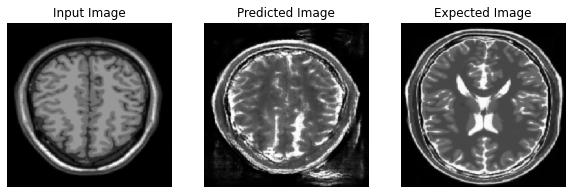

Saving checkpoint for epoch 28 at /content/Trained_model/ckpt-29


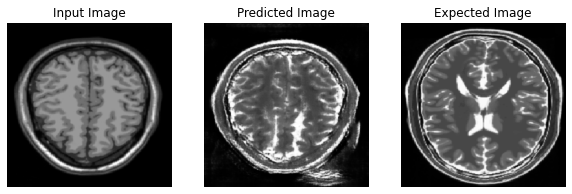

Saving checkpoint for epoch 29 at /content/Trained_model/ckpt-30


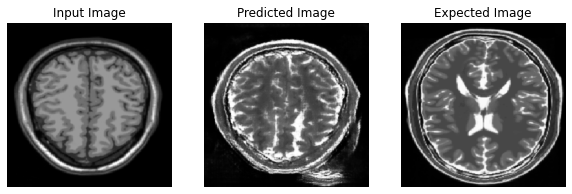

Saving checkpoint for epoch 30 at /content/Trained_model/ckpt-31


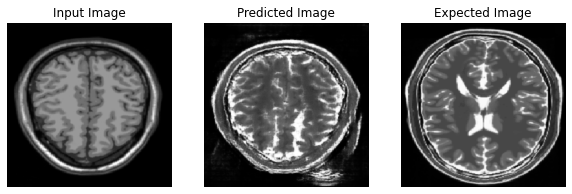

Saving checkpoint for epoch 31 at /content/Trained_model/ckpt-32


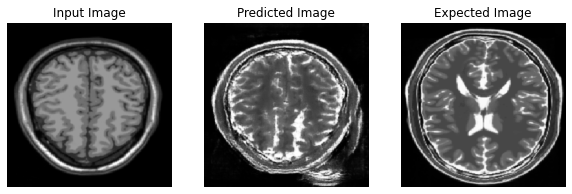

Saving checkpoint for epoch 32 at /content/Trained_model/ckpt-33


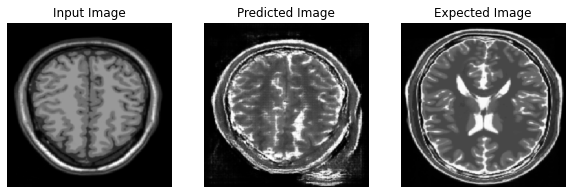

Saving checkpoint for epoch 33 at /content/Trained_model/ckpt-34


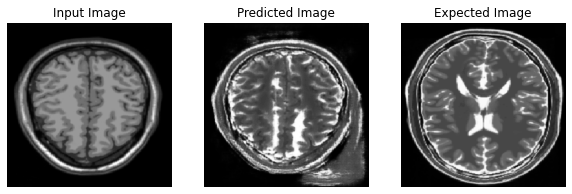

Saving checkpoint for epoch 34 at /content/Trained_model/ckpt-35


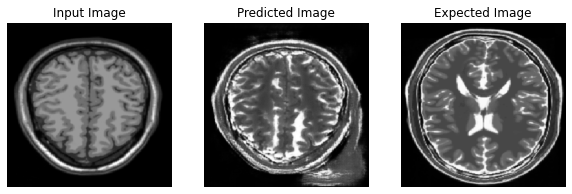

Saving checkpoint for epoch 35 at /content/Trained_model/ckpt-36


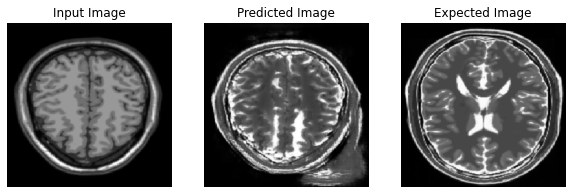

Saving checkpoint for epoch 36 at /content/Trained_model/ckpt-37


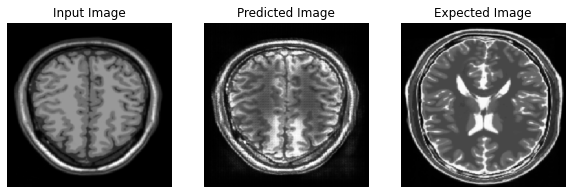

Saving checkpoint for epoch 37 at /content/Trained_model/ckpt-38


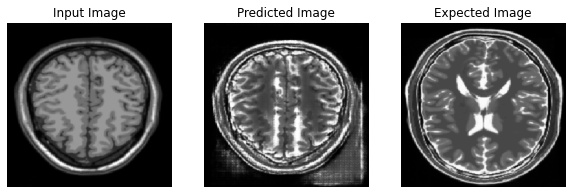

Saving checkpoint for epoch 38 at /content/Trained_model/ckpt-39


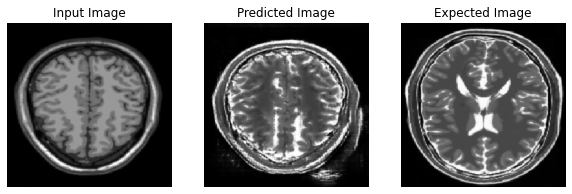

Saving checkpoint for epoch 39 at /content/Trained_model/ckpt-40


In [34]:
for epoch in range(EPOCHS):

    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)

    generate_images(generator_g, sample_tr1, sample_tr2)

    ckpt_save_path = ckpt_manager.save()
    
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

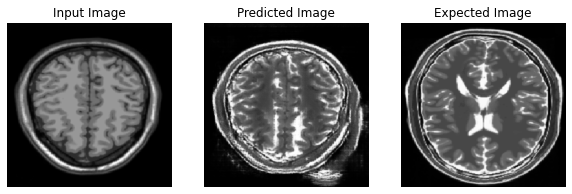

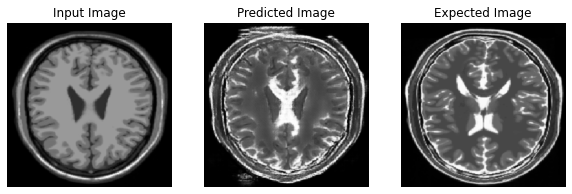

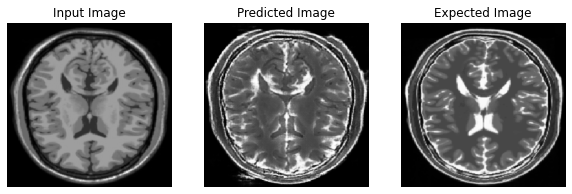

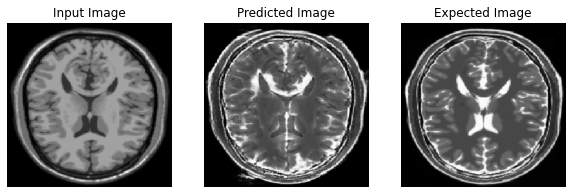

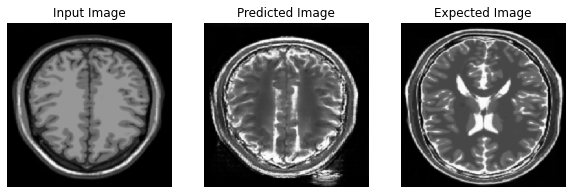

In [37]:
# Run the trained model on the test dataset

for inp in tr1.take(5):
    generate_images(generator_g, inp, sample_tr2)